In [2]:
# Add local scripts to module search path
import sys
import os
sys.path.append(os.path.realpath('../toliman-proper'))

In [3]:
from proper_tools import form_detector_image
from spirals import binarized_ringed

prescription = 'prescription_rc_quad'
# The actual values probably don't matter all that much for the purposes of this comparison.

beam_ratio = 0.4
gridsize = 2048
def binarized_ringed_650(r, phi):
    phase = 650.*1e-9*0.5
    return binarized_ringed(r, phi, phase)

toliman_settings = {
                    'diam': 0.001 * 2. * 150, 
                    'm1_fl': 571.7300 / 1000.,
                    'm1_m2_sep': 549.240/1000.,
                    'm2_fl': -23.3800/1000.,
                    'bfl': 590.000 / 1000., 
                    'm2_rad': 5.9 / 1000., 
                    'm2_strut_width': 0.01,
                    'm2_supports': 5,
                    'beam_ratio': beam_ratio,
                    'tilt_x': 0.00,
                    'tilt_y': 0.00,
                    'phase_func': binarized_ringed_650,
                    'm1_hole_rad':0.025
                    }

detector_pitch = 11.0e-6 # m/pixel on detector
npixels = 512 # Size of detector, in pixels

wl_gauss = [5.999989e-01,
            6.026560e-01,
            6.068356e-01,
            6.119202e-01,
            6.173624e-01,
            6.226281e-01,
            6.270944e-01,
            6.300010e-01 ]
weights_gaus = [5.3770e-02,
                1.1224e-01,
                1.5056e-01,
                1.7034e-01,
                1.7342e-01,
                1.5861e-01,
                1.2166e-01,
                5.9360e-02 ]

In [4]:
# First source, on axis
source_a = {
            'wavelengths': [0.6],#wl_gauss[:4],
            'weights': [1.],#weights_gaus[:4],
            'settings': toliman_settings
            }

In [4]:
viewport = 1. # mm

In [5]:
import matplotlib.pyplot as plt
import numpy as np
def view_psf(imarray, pitch_mm, viewport_mm):
    c = imarray.shape[0]/2. # Assume scaled image
    w = viewport_mm/pitch_mm
    plt.imshow(np.log10(imarray[int(c-w):int(c+w),int(c-w):int(c+w)]),cmap='viridis', extent=[x*pitch_mm for x in [-w,w,-w,w]])#,vmin=-10, vmax=-5)
    plt.colorbar()
    plt.show()

## Proper PSF using single source and `form_detector_image` 

In [6]:
image = form_detector_image(prescription, [source_a], gridsize, detector_pitch, npixels)

Couldn't load file binarized_ringed_650_2048_0.00036621093749999995.npy


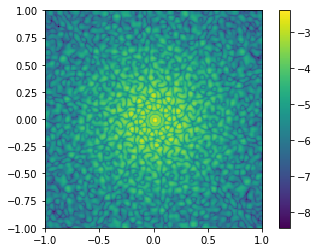

In [7]:
%matplotlib inline
view_psf(image, detector_pitch/1e-3, 1.)


## Zemax reference

In [8]:
zemax = np.load('../zemax_examples/toliman-RC-f50_SpiralPupil_psf_0deg_600nm_4mm.npy')

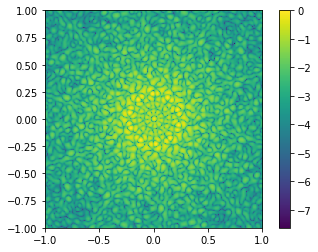

In [9]:
%matplotlib inline
view_psf(zemax, 4e-3, 1.)


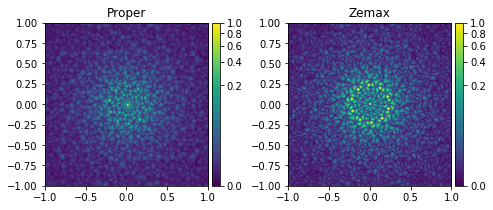

In [33]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
fig, axes = plt.subplots(1, 2, figsize=(8,3))
viewport_mm = 1.
plt.axes(axes[0])
c = image.shape[0]/2.
pitch_mm = detector_pitch/1e-3
w = viewport_mm/pitch_mm
view_proper = image[int(c-w):int(c+w),int(c-w):int(c+w)]
im =plt.imshow(view_proper/np.max(view_proper),cmap='viridis', extent=[x*pitch_mm for x in [-w,w,-w,w]],norm=mcolors.PowerNorm(gamma=0.3),vmin=0)#, vmax=-5)
plt.title('Proper')
divider = make_axes_locatable(axes[0])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.axes(axes[1])
c = zemax.shape[0]/2.
pitch_mm = 4e-3
w = viewport_mm/pitch_mm
view_zemax = zemax[int(c-w):int(c+w),int(c-w):int(c+w)]
im =plt.imshow(view_zemax/np.max(view_zemax),cmap='viridis', extent=[x*pitch_mm for x in [-w,w,-w,w]],norm=mcolors.PowerNorm(gamma=0.3),vmin=0)#, vmax=-5)
plt.title('Zemax')
divider = make_axes_locatable(axes[1])
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax)

plt.show()


In [10]:
print(zemax.shape[0])

1024


In [11]:
import numpy as np
zemax_fft = np.fft.fft2(zemax)
fshift = np.fft.fftshift(zemax_fft)

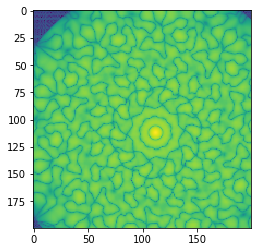

In [12]:
import matplotlib.pyplot as plt
#plt.imshow(np.angle(zemax_fft))
plt.imshow(20*np.log(np.abs(fshift))[400:600,400:600])
plt.show()

## Raw image (not going through `form_detector_image`)

In [13]:
import proper

(wavefront, sampling) = proper.prop_run(prescription, source_a['wavelengths'][0], gridsize = gridsize, QUIET=True, PRINT_INTENSITY=False, PASSVALUE=source_a['settings'])

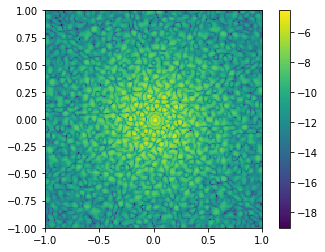

In [21]:
view_psf(np.abs(wavefront)**2, sampling/1e-3, 1.)

In [15]:
# Export FITS file
#import pyfits
#print(sampling)
#hdu = pyfits.PrimaryHDU(wavefront)
#hdu.writeto('new.fits')

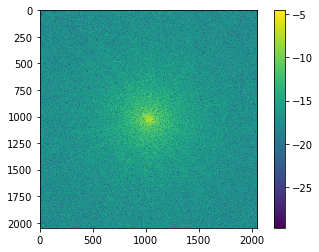

In [16]:
plt.imshow(np.log10(np.abs(wavefront)**2),cmap='viridis')
plt.colorbar()
plt.show()

In [17]:
from proper_tools import fix_prop_pixellate
resized = fix_prop_pixellate(np.abs(wavefront)**2, sampling, detector_pitch)

/home/ubuntu/miniconda/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.
/home/ubuntu/miniconda/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log10
  """Entry point for launching an IPython kernel.


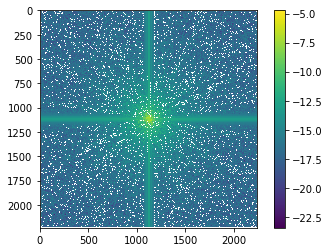

In [18]:
plt.imshow(np.log10(resized),cmap='viridis')
plt.colorbar()
plt.show()

## Export for Kieran to check

In [5]:
import proper
import pyfits
import numpy as np

def saveout(data,prefix):
    hdu = pyfits.PrimaryHDU(data)
    hdu.writeto(prefix+'.fits')
    np.savetxt(prefix+'.csv', data, delimiter=",")
    
export_images = True
if export_images is True:
    (wavefront, sampling) = proper.prop_run(prescription, .65, gridsize = gridsize, QUIET=True, PRINT_INTENSITY=False, PASSVALUE=source_a['settings'])
#    saveout(np.real(wavefront),'toliman_psf_650_re')
    saveout(np.abs(np.imag(wavefront)),'toliman_psf_650_im')